C:\Users\muni karthik\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\muni karthik\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


C:\Users\muni karthik\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\tensorflow\trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.309775173664093 | D accuracy: 75.78125] [G loss: [array(0.45212176, dtype=float32), array(0.45212176, dtype=float32), array(0.515625, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
5 [D loss: 2.6057472229003906 | D accuracy: 52.544981241226196] [G loss: [array(2.9862125, dtype=float32), array(2.9862125, dtype=float32), array(0.5026042, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


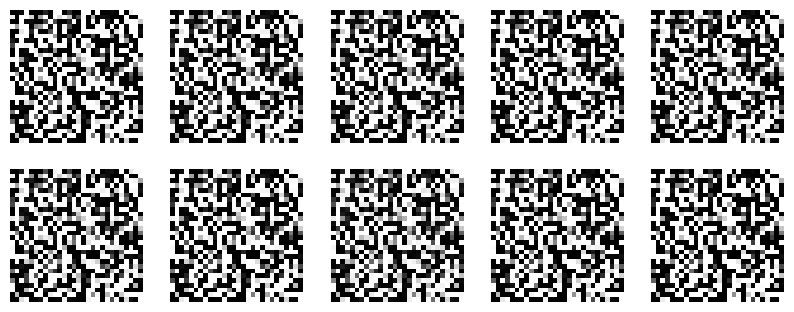

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Define the Generator model
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_dim=latent_dim))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(28*28, activation='tanh'))
    model.add(layers.Reshape((28, 28,1)))
    return model

# Define the Discriminator model
def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=input_shape))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Output probability for real/fake
    return model

# Build the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze the discriminator during GAN training
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Compile the models
latent_dim = 100
image_shape = (28, 28)

# Build and compile the discriminator
discriminator = build_discriminator(image_shape)
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the generator
generator = build_generator(latent_dim)

# Build the GAN model
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Load and prepare dataset (MNIST)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale images to [-1, 1] for better convergence
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)

# Define batch size and number of epochs
batch_size = 64
epochs = 10
sample_interval = 5  # Interval to save generated images

# Function to train the GAN
def train_gan(epochs, batch_size, sample_interval):
    half_batch = batch_size // 2

    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]
        fake_images = generator.predict(np.random.randn(half_batch, latent_dim))

        # Labels for real and fake images
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator (via GAN model)
        noise = np.random.randn(batch_size, latent_dim)
        valid_labels = np.ones((batch_size, 1))  # Wants the generator to fool the discriminator
        g_loss = gan.train_on_batch(noise, valid_labels)

        # Print progress and save generated images periodically
        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100*d_loss[1]}] [G loss: {g_loss}]")
            save_generated_images(epoch)

# Save generated images at intervals
def save_generated_images(epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.randn(examples, latent_dim)
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"gan_generated_image_{epoch}.png")
    plt.close()

def generate_new_images(num_images=10):
    noise = np.random.randn(num_images, latent_dim)  # Random noise
    generated_images = generator.predict(noise)
    
    # Rescale back to [0, 1] for visualization
    generated_images = (generated_images + 1) / 2.0
    
    # Display generated images
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

# Start training
train_gan(epochs, batch_size, sample_interval)

generate_new_images(num_images=10)